# This file is for creating the test accuracies of the varying models

In [1]:
# Imports
import sys
import pandas as pd
import numpy as np
from rfgap import RFGAP


# Get the data
sys.path.insert(0, '/yunity/arusty/PF-GAP')

static2024 = pd.read_csv('../data/static2024.csv')
static2023 = pd.read_csv('../data/static2023.csv')
static2022 = pd.read_csv('../data/static2022.csv')
static2025 = pd.read_csv('../data/static2025.csv')
time_series = np.array(pd.read_csv('../data/time_series.csv'))
labels = pd.read_csv('../data/labels.csv')
labels = np.array(labels).flatten()


from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test, static2023_train, static2023_test, static2024_train, static2024_test = train_test_split(time_series, 
labels, static2023, static2024, test_size=0.2, random_state=42)


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import pandas as pd


def determine_static(fold):
    if fold < 2:
        static_train = static2022
        static_test = static2023
    elif fold < 4:
        static_train = static2023
        static_test = static2024
    else:
        static_train = static2024
        static_test = static2025

    return np.array(static_train), np.array(static_test)

def get_cross_validation_results(get_predictions_method):
    # Set up cross-validation
    skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

    results = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(time_series, labels)):
        print(f"Fold {fold + 1}/{skf.n_splits}: {len(train_idx)} train samples, {len(test_idx)} test samples")
        # Split data
        X_train, X_test = time_series[train_idx], time_series[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        
        static_train, static_test = determine_static(fold)

        y_pred = get_predictions_method(X_train, y_train, X_test, static_train[train_idx], static_test[test_idx])
        
        
        # RF metrics
        rf_f1 = f1_score(y_test, y_pred, average='weighted')
        rf_recall = recall_score(y_test, y_pred, average='weighted')
        rf_precision = precision_score(y_test, y_pred, average='weighted')
        rf_acc = accuracy_score(y_test, y_pred)
        
        results.append({
            'fold': fold,
            'train_idx': train_idx,
            'test_idx': test_idx,
            'rf_f1': rf_f1,
            'rf_recall': rf_recall,
            'rf_precision': rf_precision,
            'rf_accuracy': rf_acc
        })

    # Convert results to DataFrame
    return pd.DataFrame(results)




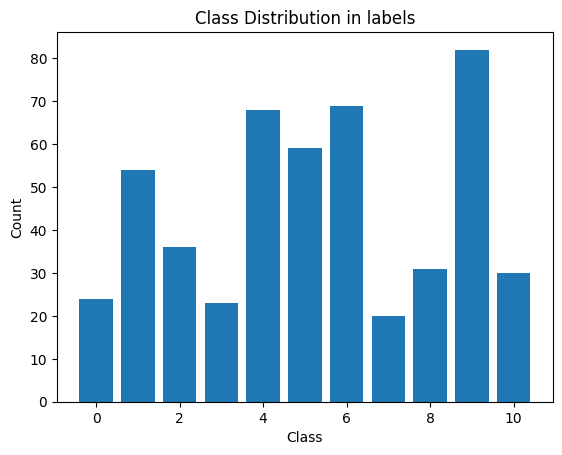

In [2]:
# Class distribuation
import matplotlib.pyplot as plt

unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in labels')
plt.show()

# RF - Rocket

In [4]:
from RFGAP_Rocket.RFGAP_Rocket import RFGAP_Rocket
rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=512)
rocket.fit(X_train, y_train, static2023_train, weights = None)
pred = rocket.predict(X_test, static2024_test)

score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")


Accuracy: 0.46


In [8]:
rocket.rocket.transform(X_train).shape

(396, 4032)

In [3]:
def get_rocket_pred(X_train, y_train, X_test, static_train, static_test):
    rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=512)
    
    rocket.fit(X_train, y_train, static_train, weights = None)
    return rocket.predict(X_test, static_test)



In [4]:
get_cross_validation_results(get_rocket_pred)

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

,fold,train_idx,test_idx,rf_f1,rf_recall,rf_precision,rf_accuracy
0,0,"[0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[1, 2, 5, 21, 23, 28, 31, 36, 63, 75, 85, 98, ...",0.437647,0.457831,0.446787,0.457831
1,1,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0, 4, 22, 29, 30, 39, 42, 48, 50, 53, 55, 65,...",0.467416,0.493976,0.510756,0.493976
2,2,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15...","[7, 13, 18, 20, 35, 44, 60, 61, 70, 78, 91, 96...",0.541923,0.554217,0.552932,0.554217
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...","[9, 11, 17, 25, 27, 34, 37, 38, 40, 46, 51, 57...",0.499335,0.518072,0.535049,0.518072
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[8, 16, 24, 26, 33, 47, 52, 54, 56, 71, 73, 74...",0.441403,0.475610,0.533573,0.475610
5,5,"[0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 18, 2...","[3, 6, 10, 12, 14, 15, 19, 32, 41, 43, 45, 49,...",0.433894,0.439024,0.488796,0.439024


# RDST TRIALS

In [2]:
from RDST.rdst import RDST_GAP

rdst = RDST_GAP(save_transformed_data = True)
rdst.fit(X_train, y_train, static = static2023_train)
pred = rdst.predict(X_test, static = static2024_test)
score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")

Accuracy: 0.59


In [3]:
def get_rdst_pred(X_train, y_train, X_test, static_train, static_test):
    rdst = RDST_GAP(save_transformed_data = True)
    rdst.fit(X_train, y_train, static = static_train)
    return rdst.predict(X_test, static = static_test)
    

get_cross_validation_results(get_rdst_pred)

Fold 1/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,fold,train_idx,test_idx,rf_f1,rf_recall,rf_precision,rf_accuracy
0,0,"[0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[1, 2, 5, 21, 23, 28, 31, 36, 63, 75, 85, 98, ...",0.520993,0.554217,0.571544,0.554217
1,1,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0, 4, 22, 29, 30, 39, 42, 48, 50, 53, 55, 65,...",0.503016,0.518072,0.537241,0.518072
2,2,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15...","[7, 13, 18, 20, 35, 44, 60, 61, 70, 78, 91, 96...",0.633532,0.650602,0.656008,0.650602
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...","[9, 11, 17, 25, 27, 34, 37, 38, 40, 46, 51, 57...",0.630469,0.662651,0.670442,0.662651
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[8, 16, 24, 26, 33, 47, 52, 54, 56, 71, 73, 74...",0.587776,0.609756,0.632520,0.609756
5,5,"[0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 18, 2...","[3, 6, 10, 12, 14, 15, 19, 32, 41, 43, 45, 49,...",0.571089,0.585366,0.631133,0.585366


# QUANT TRIALS

In [2]:
from QGAP.qgap import QGAP
qgap= QGAP(matrix_type="dense")

qgap.fit(X_train,y_train, static = static2023_train)
pred = qgap.predict(X_test, static = static2024_test)
score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")

Accuracy: 0.59


In [3]:
def get_qgap_pred(X_train, y_train, X_test, static_train, static_test):
    qgap = QGAP(matrix_type="dense")
    qgap.fit(X_train, y_train, static = static_train)
    return qgap.predict(X_test, static = static_test)
    

get_cross_validation_results(get_qgap_pred)

Fold 1/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,fold,train_idx,test_idx,rf_f1,rf_recall,rf_precision,rf_accuracy
0,0,"[0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[1, 2, 5, 21, 23, 28, 31, 36, 63, 75, 85, 98, ...",0.529739,0.542169,0.575636,0.542169
1,1,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0, 4, 22, 29, 30, 39, 42, 48, 50, 53, 55, 65,...",0.573828,0.602410,0.606053,0.602410
2,2,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15...","[7, 13, 18, 20, 35, 44, 60, 61, 70, 78, 91, 96...",0.681893,0.698795,0.698289,0.698795
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...","[9, 11, 17, 25, 27, 34, 37, 38, 40, 46, 51, 57...",0.572917,0.590361,0.604100,0.590361
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[8, 16, 24, 26, 33, 47, 52, 54, 56, 71, 73, 74...",0.588058,0.609756,0.626150,0.609756
5,5,"[0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 18, 2...","[3, 6, 10, 12, 14, 15, 19, 32, 41, 43, 45, 49,...",0.552714,0.573171,0.579343,0.573171


# RedCommets

In [2]:
from Redcomets.Redcomets import REDCOMETS
rc = REDCOMETS(variant = 3, static = static2023_train, debug_mode=False)
rc.fit(X_train, y_train)


min_neighbours: 15
max_neighbours: 68


X_smote shape: (748, 829)
y_smote shape: (748,)


X_sfa shape: (748, 125)
X_sfa shape: (748, 127)
X_sfa shape: (748, 96)
X_sfa shape: (748, 13)
X_sfa shape: (748, 71)
X_sfa shape: (748, 110)
X_sfa shape: (748, 99)
X_sfa shape: (748, 38)
X_sfa shape: (748, 79)
X_sfa shape: (748, 122)
X_sfa shape: (748, 43)
X_sfa shape: (748, 61)
X_sfa shape: (748, 67)
X_sfa shape: (748, 96)
X_sfa shape: (748, 65)
X_sfa shape: (748, 65)
X_sfa shape: (748, 6)
X_sfa shape: (748, 13)
X_sfa shape: (748, 22)
X_sfa shape: (748, 89)
X_sfa shape: (748, 20)
X_sfa shape: (748, 19)
X_sfa shape: (748, 64)
X_sfa shape: (748, 113)
X_sfa shape: (748, 85)
X_sfa shape: (748, 33)
X_sfa shape: (748, 54)
X_sfa shape: (748, 112)
X_sfa shape: (748, 79)
X_sfa shape: (748, 3)
X_sfa shape: (748, 46)
X_sfa shape: (748, 34)
X_sfa shape: (748, 93)
X_sfa shape: (748, 35)
X_sfa shape: (748, 106)
X_sfa shape: (748, 35)
X_sfa shape: (748, 50)
X_sfa shape: (748, 99)
X_sfa shape: (748, 73)
X_sfa sh

REDCOMETS(debug_mode=True,
          static=      PE Ratio   PB Ratio   PS Ratio       ROE       ROA  Debt/Equity  \
56   36.875910   2.493953   1.209477  0.187583  0.036626      101.467   
227  35.726387 -14.232141  11.074953 -0.483475  0.074086       74.277   
391  15.647273   2.192378   4.616868  0.152219  0.119516       10.012   
329  51.739147  19.432201  11.619553  0.262673  0.110974       72.513   
220  21.952726   7.276124   2.045558 -1.402486 -0.227690      297.468   
..         ...        ...        ...       ...       ...          .....
220          1.600      -0.297664              -0.145              0.0785   
..             ...            ...                 ...                 ...   
106          0.867       0.221288               0.094             -0.0610   
270          3.174       0.366868               0.163              0.0500   
348          1.318       0.211297              -0.058             -0.1120   
435          5.258       0.371597               0.111              0.0670   
102          1.703       0.128768               0.035              0.2260   

       Market Cap  
56   1.426579e+10  
227  5.256173e+10  
391  6.556876e+10  
329  4.667961e+11  
220  8.459406e+09  
..            ...  
106  2.239379e+11  
270  1.388217e+10  
348  3.371016e+10  
435  1.475250e+11  
102  2.466268e+10  

[396 rows x 11 columns])

In [4]:
pred = rc.predict(X_test, static = static2024_test)
score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")

X shape before reshapping: (100, 829)


Static shape: (100, 11)


X shape: (100, 829)


Static shape: (100, 11)


Accuracy: 0.75


In [5]:
def get_redcomets_pred(X_train, y_train, X_test, static_train, static_test):
    rc = REDCOMETS(static = static_train, variant=3)
    rc.fit(X_train, y_train)
    return rc.predict(X_test, static = static_test)
    

get_cross_validation_results(get_redcomets_pred)

Fold 1/6: 413 train samples, 83 test samples
Fold 2/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3/6: 413 train samples, 83 test samples
Fold 4/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,fold,train_idx,test_idx,rf_f1,rf_recall,rf_precision,rf_accuracy
0,0,"[0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[1, 2, 5, 21, 23, 28, 31, 36, 63, 75, 85, 98, ...",0.764468,0.759036,0.832631,0.759036
1,1,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0, 4, 22, 29, 30, 39, 42, 48, 50, 53, 55, 65,...",0.765125,0.783133,0.800383,0.783133
2,2,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15...","[7, 13, 18, 20, 35, 44, 60, 61, 70, 78, 91, 96...",0.808081,0.819277,0.835477,0.819277
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...","[9, 11, 17, 25, 27, 34, 37, 38, 40, 46, 51, 57...",0.719785,0.734940,0.735499,0.734940
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[8, 16, 24, 26, 33, 47, 52, 54, 56, 71, 73, 74...",0.733237,0.756098,0.788618,0.756098
5,5,"[0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 18, 2...","[3, 6, 10, 12, 14, 15, 19, 32, 41, 43, 45, 49,...",0.699662,0.707317,0.752716,0.707317


# PF GAP

In [23]:
X_train

array([[-0.03484876,  0.01566482,  0.00153123, ...,  0.02262156,
         0.00268764,  0.04164949],
       [ 0.00958062, -0.02667377,  0.00250313, ...,  0.02957135,
         0.02240791,  0.01857355],
       [-0.01639289, -0.03518049,  0.0055787 , ...,  0.04274342,
         0.00403079,  0.02026033],
       ...,
       [ 0.02485801, -0.03577665, -0.00026312, ...,  0.01467947,
         0.00762799,  0.03700319],
       [ 0.00104946, -0.02085956, -0.00032121, ...,  0.00789777,
         0.03672663,  0.06559324],
       [ 0.00108144,  0.00707157,  0.00165771, ...,  0.00688384,
        -0.01656236, -0.01879955]])

In [22]:
sys.path.insert(0, '/yunity/arusty/PF-GAP/PFGAP')

from PFGAP.PyPFGAP import PyPFGAP
pf = PyPFGAP()
pf.fit(X_train, y_train)
pred = pf.predict(X_test)
score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")

reading file [train]:Error executing PFGAP.jar: Command '['java', '-jar', '-Xmx1g', '/yunity/arusty/PF-GAP/PFGAP/Application/PFGAP.jar', '-train=/yunity/arusty/data/train', '-test=/yunity/arusty/data/test', '-out=output', '-repeats=1', '-trees=18', '-r=5', '-on_tree=true', '-shuffle=false', '-export=1', '-verbosity=1', '-csv_has_header=false', '-target_column=first', '-getprox=true', '-savemodel=true', '-modelname=PF']' returned non-zero exit status 255.



Fatal Error:: For input string: "1.0"

java.lang.NumberFormatException: For input string: "1.0"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:665)
	at java.base/java.lang.Integer.parseInt(Integer.java:781)
	at core.CSVReader.readCSVToListDataset(CSVReader.java:88)
	at core.ExperimentRunner.run(ExperimentRunner.java:37)
	at application.PFApplication.main(PFApplication.java:113)


FileNotFoundError: [Errno 2] No such file or directory: 'ForestProximities.txt'

# Fresh Prince

In [7]:
from FreshPrince.FreshPrince import FreshPRINCE_GAP
fp = FreshPRINCE_GAP()
fp.fit(X_train, y_train, static = static2023_train)
pred = fp.predict(X_test, static = static2024_test)
score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")

Accuracy: 0.79


In [8]:
def get_fresh_pred(X_train, y_train, X_test, static_train, static_test):
    fp = FreshPRINCE_GAP()
    fp.fit(X_train, y_train, static = static_train)
    return fp.predict(X_test, static = static_test)
    

get_cross_validation_results(get_fresh_pred)

Fold 1/6: 413 train samples, 83 test samples
Fold 2/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5/6: 414 train samples, 82 test samples
Fold 6/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,fold,train_idx,test_idx,rf_f1,rf_recall,rf_precision,rf_accuracy
0,0,"[0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[1, 2, 5, 21, 23, 28, 31, 36, 63, 75, 85, 98, ...",0.711474,0.722892,0.772780,0.722892
1,1,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0, 4, 22, 29, 30, 39, 42, 48, 50, 53, 55, 65,...",0.683653,0.710843,0.696615,0.710843
2,2,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15...","[7, 13, 18, 20, 35, 44, 60, 61, 70, 78, 91, 96...",0.715095,0.734940,0.727574,0.734940
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...","[9, 11, 17, 25, 27, 34, 37, 38, 40, 46, 51, 57...",0.678999,0.698795,0.701612,0.698795
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[8, 16, 24, 26, 33, 47, 52, 54, 56, 71, 73, 74...",0.772111,0.780488,0.806073,0.780488
5,5,"[0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 18, 2...","[3, 6, 10, 12, 14, 15, 19, 32, 41, 43, 45, 49,...",0.689224,0.707317,0.719620,0.707317


# Distance Measures
These are created just by applying the distances directly to the time series. 

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
import seaborn as sns

# Function to plot heatmap sorted by class
def heatmap_sorted(dist_matrix, labels, title="Proximity Matrix Heatmap (Sorted by Class)"):
    sort_idx = np.argsort(labels)
    sorted_matrix = dist_matrix[sort_idx][:, sort_idx]
    sorted_labels = labels[sort_idx]
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_matrix, cmap='viridis', square=True, cbar=True)
    plt.title(title)
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Sample Index (sorted)")

    # Find indices where the class changes
    class_change_indices = np.where(np.diff(sorted_labels) != 0)[0] + 1
    for idx in class_change_indices:
        plt.axvline(idx, color='white', linestyle='--', linewidth=1)
        plt.axhline(idx, color='white', linestyle='--', linewidth=1)

    plt.show()

def evaluate_knn_on_distance_matrix(distance_matrix, labels, n_neighbors=1):
    """
    Perform 6-fold cross-validation using KNN with a precomputed distance matrix.
    Args:
        distance_matrix (np.ndarray): Square distance matrix (n_samples x n_samples)
        labels (np.ndarray): Array of labels (n_samples,)
        n_neighbors (int): Number of neighbors for KNN (default 1)
    Returns:
        pd.DataFrame: DataFrame with accuracy, F1, precision, and recall for each fold
    """
    heatmap_sorted(distance_matrix, labels)

    skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    results = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(distance_matrix, labels)):
        # Extract the relevant submatrices for precomputed distances
        train_dist = distance_matrix[np.ix_(train_idx, train_idx)]
        test_dist = distance_matrix[np.ix_(test_idx, train_idx)]
        y_train, y_test = labels[train_idx], labels[test_idx]

        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='precomputed')
        knn.fit(train_dist, y_train)
        y_pred = knn.predict(test_dist)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        results.append({
            'fold': fold,
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        })
    return pd.DataFrame(results)


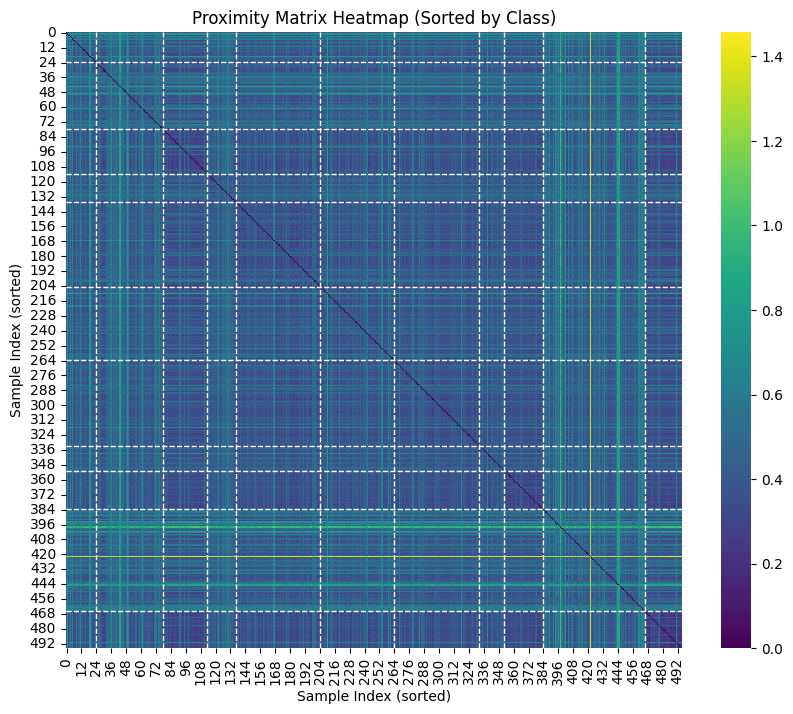

,fold,accuracy,f1,precision,recall
0,0,0.674699,0.667987,0.673134,0.674699
1,1,0.686747,0.675776,0.749636,0.686747
2,2,0.734940,0.730772,0.755795,0.734940
3,3,0.698795,0.680527,0.685197,0.698795
4,4,0.768293,0.758545,0.775304,0.768293
5,5,0.670732,0.666544,0.698763,0.670732


In [22]:
dtw = np.load('../data/prox_files/dtw_matrix.npy')
evaluate_knn_on_distance_matrix(dtw, labels, n_neighbors=1)

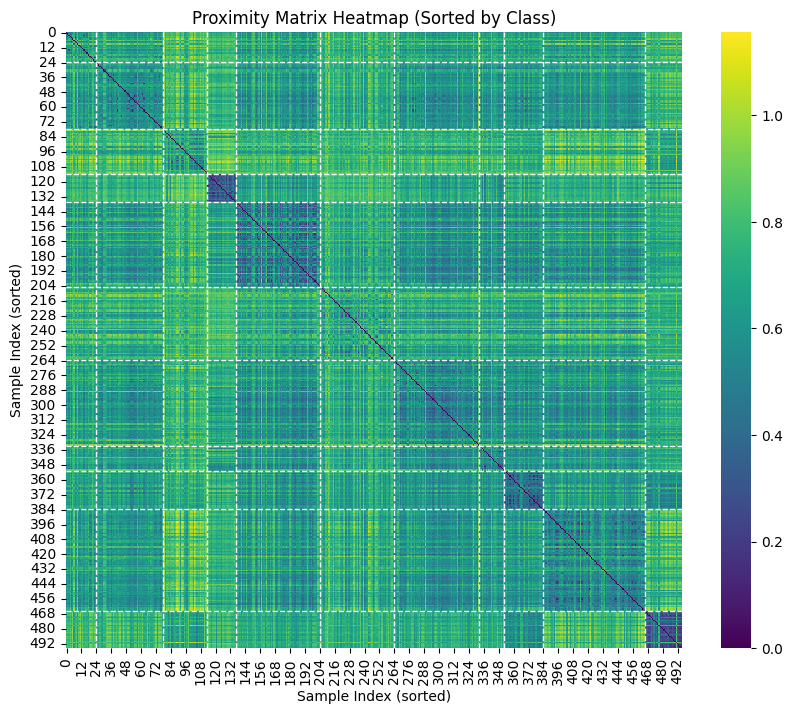

,fold,accuracy,f1,precision,recall
0,0,0.891566,0.890087,0.898482,0.891566
1,1,0.903614,0.899153,0.908306,0.903614
2,2,0.819277,0.816757,0.829030,0.819277
3,3,0.843373,0.845279,0.863558,0.843373
4,4,0.878049,0.876971,0.889141,0.878049
5,5,0.878049,0.866844,0.900898,0.878049


In [23]:
cosine = np.load('../data/prox_files/cosine_matrix.npy')
evaluate_knn_on_distance_matrix(cosine, labels, n_neighbors=1)